# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [171]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import time
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import random
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import xgboost as xgb

from tqdm import tqdm
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from prettytable import PrettyTable,MSWORD_FRIENDLY
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS 

In [2]:
os.chdir('/home/sujit/Downloads/Windows_Files/')
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).

# filtered_data= pd.read_csv('Reviews.csv',index_col=None)
# filtered_data=filtered_data[filtered_data['Score']!=3]
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:31<00:00, 2751.58it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [23]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation

In [109]:
#Bow
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train_data['CleanedText'])

X_Train = count_vect.transform(X_train_data['CleanedText'])
print("Shape of out text BOW vectorizer ",X_Train.get_shape())
print("Number of unique words ", X_Train.get_shape()[1])

X_Test = count_vect.transform(X_test_data['CleanedText'])
print("Shape of out text BOW vectorizer ",X_Test.get_shape())
print("Number of unique words ", X_Test.get_shape()[1])

Shape of out text BOW vectorizer  (73145, 50169)
Number of unique words  50169
Shape of out text BOW vectorizer  (14628, 50169)
Number of unique words  50169


In [110]:
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_Train)
X_Train_Scaler = scaler_x.transform(X_Train)
X_Test_Scaler = scaler_x.transform(X_Test)

/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [112]:
# Hyper Parameters
params = {'n_estimators':[120,300,500,800],
         'max_depth':[2,5,8,15,None]}

In [116]:
# Random Forest
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,
                       n_jobs=-1, random_state=42, verbose=0, class_weight='balanced')

scorer=make_scorer(roc_auc_score,average='weighted',needs_threshold=True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [117]:
%%time
start_time=time.time()
clf.fit(X_Train_Scaler,Y_train)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.1min finished


CPU times: user 22min 34s, sys: 1.05 s, total: 22min 35s
Wall time: 18min 57s


In [118]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.934240406385499
The Best Parameter obtained from the Grid Search is :  {'n_estimators': 300, 'max_depth': None}


In [119]:
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,n_jobs=-1, verbose=0, 
                             class_weight='balanced',min_samples_split=clf.best_params_['n_estimators'],
                          max_depth=clf.best_params_['max_depth'],random_state=42)

In [120]:
model.fit(X_Train_Scaler,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=300, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [122]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the Random Forest Classifier for N-Estimators = ',clf.best_params_['n_estimators'],'Max Depth = %0.0f ',clf.best_params_['max_depth'],'is', Test_score)

The Test Score of the Naive Bayes Classifier for N-Estimators =  300 Max Depth = %0.0f  None is 0.7451788861959564


In [123]:
Conf_matrix=confusion_matrix(Y_test, pred)

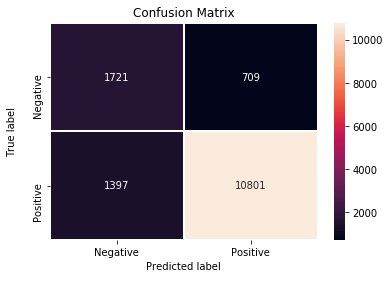

In [124]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

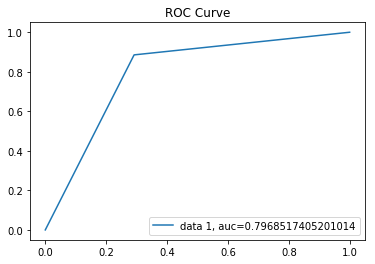

In [125]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [126]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [127]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [130]:
Pretty.add_row(["Random Forest","Bag of Words",
                (clf.best_params_['n_estimators'],clf.best_params_['max_depth']),
                elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [131]:
print(Pretty)

|     Model     | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|    XG Boost   |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
|    XG Boost   |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |
|    XG Boost   |       Average W2V       |    (50, 13, 0.01)    | 1068.6631660461426 |      0.91     |    0.82    |
|    XG Boost   |   TF - IDF Weigted W2V  |   (50, 15, 0.005)    | 1068.6631660461426 |      0.89     |    0.82    |
| Random Forest |       Bag of Words      |     (300, None)      | 1137.6648106575012 |      0.93     |    0.75    |


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation

In [172]:
# Function for defining Feature Importnace and plotting them using Wordcloud

def Feature_Importance(n,Vectorizer,colormap1):
    coefs_with_fnames=sorted(zip(model.feature_importances_,Vectorizer.get_feature_names()))
    Features_=coefs_with_fnames[:-(n+1):-1]

    Features=[]
    for each in Features_:
        Features.append(each[1].encode('utf-8'))

    # Plotting Wordcloud
    
    wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42,
                          colormap=colormap1
                         ).generate(str(Features))

    fig = plt.figure(1,figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Top 20 Important Features \n'
              , fontsize=25,fontname='cursive',color='black')
    plt.show()
    
    return Features

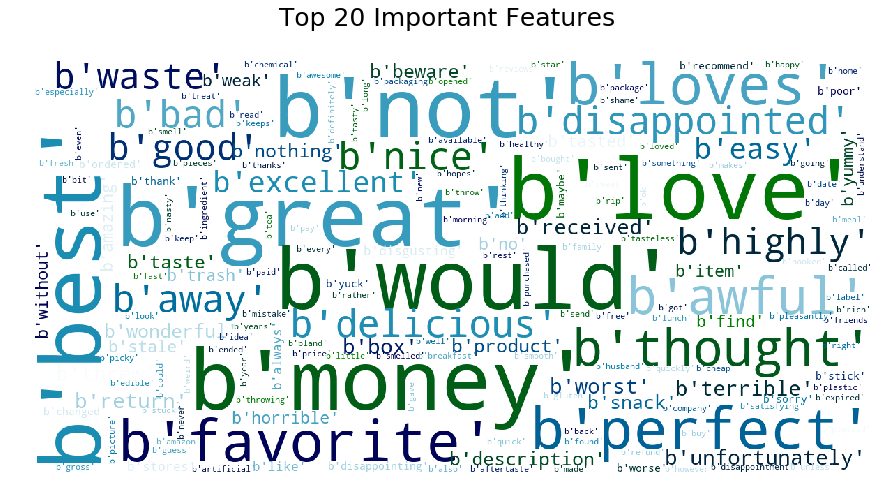

In [169]:
Features= Feature_Importance(200,count_vect,"ocean")

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

In [173]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_data['CleanedText'])

X_Train = tf_idf_vect.transform(X_train_data['CleanedText'])
print("the shape of out text TFIDF vectorizer ",X_Train.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Train.get_shape()[1])

X_Test = tf_idf_vect.transform(X_test_data['CleanedText'])
print("the shape of out text TFIDF vectorizer ",X_Test.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Test.get_shape()[1])

the shape of out text TFIDF vectorizer  (73145, 43593)
the number of unique words including both unigrams and bigrams  43593
the shape of out text TFIDF vectorizer  (14628, 43593)
the number of unique words including both unigrams and bigrams  43593


In [174]:
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_Train)
X_Train_Scaler = scaler_x.transform(X_Train)
X_Test_Scaler = scaler_x.transform(X_Test)

In [175]:
# Hyper Parameters
params = {'n_estimators':[120,300,500,800],
         'max_depth':[2,5,8,15,None]}

In [176]:
# Random Forest
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,
                       n_jobs=-1, random_state=42, verbose=0, class_weight='balanced')

scorer=make_scorer(roc_auc_score,average='weighted',needs_threshold=True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [177]:
%%time
start_time=time.time()
clf.fit(X_Train_Scaler,Y_train)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.0min finished


CPU times: user 45min 47s, sys: 1.81 s, total: 45min 49s
Wall time: 35min 52s


In [178]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.9412554815204756
The Best Parameter obtained from the Grid Search is :  {'n_estimators': 800, 'max_depth': None}


In [179]:
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,n_jobs=-1, verbose=0, 
                             class_weight='balanced',min_samples_split=clf.best_params_['n_estimators'],
                          max_depth=clf.best_params_['max_depth'],random_state=42)

In [180]:
model.fit(X_Train_Scaler,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=800, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [181]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the Random Forest Classifier for N-Estimators = ',clf.best_params_['n_estimators'],'Max Depth = %0.0f ',clf.best_params_['max_depth'],'is', Test_score)

The Test Score of the Random Forest Classifier for N-Estimators =  800 Max Depth = %0.0f  None is 0.7585840367286416


In [182]:
Conf_matrix=confusion_matrix(Y_test, pred)

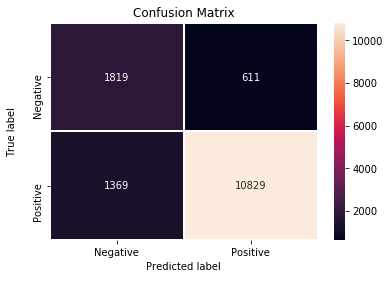

In [183]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

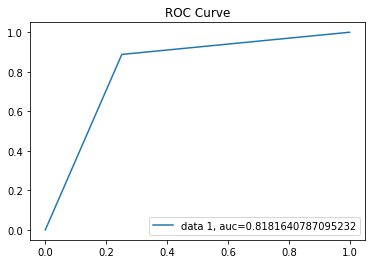

In [184]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [185]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [186]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [188]:
Pretty.add_row(["Random Forest","T - IDF",
                (clf.best_params_['n_estimators'],clf.best_params_['max_depth']),
                elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [189]:
print(Pretty)

|     Model     | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|    XG Boost   |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
|    XG Boost   |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |
|    XG Boost   |       Average W2V       |    (50, 13, 0.01)    | 1068.6631660461426 |      0.91     |    0.82    |
|    XG Boost   |   TF - IDF Weigted W2V  |   (50, 15, 0.005)    | 1068.6631660461426 |      0.89     |    0.82    |
| Random Forest |       Bag of Words      |     (300, None)      | 1137.6648106575012 |      0.93     |    0.75    |
| Random Forest |       Bag of Words      |     (800, None)      | 2152.808084964752  |      0.94     |    0.76    |


### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

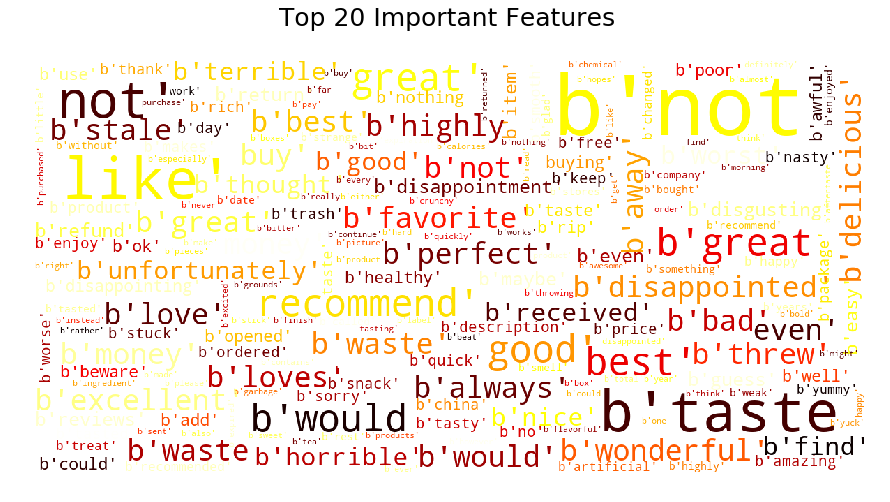

In [190]:
Features= Feature_Importance(200,tf_idf_vect,"hot")

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

In [191]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train_data['CleanedText']:
    list_of_sentance.append(sentance.split())

In [192]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X_test_data['CleanedText']:
    list_of_sentance_test.append(sentance.split())

In [193]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=10,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    

[('fantastic', 0.8389848470687866), ('good', 0.8367034196853638), ('terrific', 0.808373212814331), ('excellent', 0.8053322434425354), ('awesome', 0.8026216626167297), ('wonderful', 0.7490705251693726), ('perfect', 0.7421305179595947), ('fabulous', 0.7127804160118103), ('amazing', 0.707833468914032), ('decent', 0.7010031938552856)]
[('best', 0.7527667284011841), ('greatest', 0.7355169057846069), ('nastiest', 0.7334026098251343), ('tastiest', 0.7024081945419312), ('closest', 0.6549410223960876), ('horrible', 0.6056369543075562), ('disgusting', 0.6011358499526978), ('softest', 0.5925934314727783), ('smoothest', 0.5859032869338989), ('nicest', 0.5713656544685364)]


In [194]:
w2v_words = list(w2v_model.wv.vocab)

In [195]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 73145/73145 [02:35<00:00, 469.28it/s]

73145
50


In [196]:
X_train=sent_vectors

In [197]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 14628/14628 [00:25<00:00, 584.86it/s]

14628
50


In [198]:
X_Test=sent_vectors

In [206]:
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_train)
X_Train_Scaler = scaler_x.transform(X_train)
X_Test_Scaler = scaler_x.transform(X_Test)

In [207]:
# Hyper Parameters
params = {'n_estimators':[120,300,500,800],
         'max_depth':[2,5,8,15,None]}

In [208]:
# Random Forest
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,
                       n_jobs=-1, random_state=42, verbose=0, class_weight='balanced')

scorer=make_scorer(roc_auc_score,average='weighted',needs_threshold=True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [209]:
%%time
start_time=time.time()
clf.fit(X_Train_Scaler,Y_train)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.6min finished


CPU times: user 3min 48s, sys: 793 ms, total: 3min 48s
Wall time: 13min 39s


In [210]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.8944977584802243
The Best Parameter obtained from the Grid Search is :  {'n_estimators': 300, 'max_depth': None}


In [211]:
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,n_jobs=-1, verbose=0, 
                             class_weight='balanced',min_samples_split=clf.best_params_['n_estimators'],
                          max_depth=clf.best_params_['max_depth'],random_state=42)

In [212]:
model.fit(X_Train_Scaler,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=300, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [213]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the Random Forest Classifier for N-Estimators = ',clf.best_params_['n_estimators'],
      'Max Depth = %0.0f ',clf.best_params_['max_depth'],'is', Test_score)

The Test Score of the Random Forest Classifier for N-Estimators =  300 Max Depth = %0.0f  None is 0.7023132403374821


In [214]:
Conf_matrix=confusion_matrix(Y_test, pred)

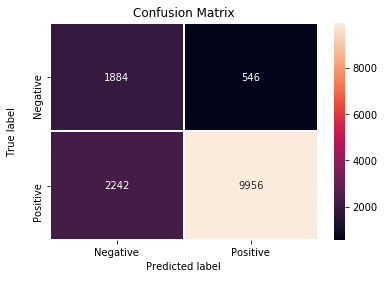

In [215]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

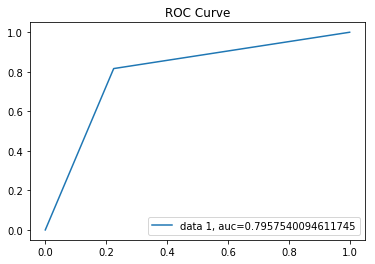

In [216]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [217]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [218]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [219]:
Pretty.add_row(["Random Forest","Average W2V",
                (clf.best_params_['n_estimators'],clf.best_params_['max_depth']),
                elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [220]:
print(Pretty)

|     Model     | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|    XG Boost   |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
|    XG Boost   |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |
|    XG Boost   |       Average W2V       |    (50, 13, 0.01)    | 1068.6631660461426 |      0.91     |    0.82    |
|    XG Boost   |   TF - IDF Weigted W2V  |   (50, 15, 0.005)    | 1068.6631660461426 |      0.89     |    0.82    |
| Random Forest |       Bag of Words      |     (300, None)      | 1137.6648106575012 |      0.93     |    0.75    |
| Random Forest |       Bag of Words      |     (800, None)      | 2152.808084964752  |      0.94     |    0.76    |
| Random Forest |       Average W2V       |     (300, None)      | 819.7472834587097  |      0.89     |    0.7     |


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

In [221]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_data['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [222]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 73145/73145 [1:00:27<00:00, 20.16it/s]


In [223]:
X_Train=tfidf_sent_vectors

In [224]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 14628/14628 [10:46<00:00, 22.62it/s]


In [225]:
X_Test=tfidf_sent_vectors

In [226]:
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_Train)
X_Train_Scaler = scaler_x.transform(X_Train)
X_Test_Scaler = scaler_x.transform(X_Test)

In [227]:
# Hyper Parameters
params = {'n_estimators':[120,300,500,800],
         'max_depth':[2,5,8,15,None]}

In [228]:
# Random Forest
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,
                       n_jobs=-1, random_state=42, verbose=0, class_weight='balanced')

scorer=make_scorer(roc_auc_score,average='weighted',needs_threshold=True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [229]:
%%time
start_time=time.time()
clf.fit(X_Train_Scaler,Y_train)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min finished


CPU times: user 3min 56s, sys: 1.1 s, total: 3min 57s
Wall time: 14min


In [230]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.8711062825223606
The Best Parameter obtained from the Grid Search is :  {'n_estimators': 300, 'max_depth': None}


In [231]:
model=RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=True,n_jobs=-1, verbose=0, 
                             class_weight='balanced',min_samples_split=clf.best_params_['n_estimators'],
                          max_depth=clf.best_params_['max_depth'],random_state=42)

In [232]:
model.fit(X_Train_Scaler,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=300, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [233]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the Random Forest Classifier for N-Estimators = ',clf.best_params_['n_estimators'],
      'Max Depth = %0.0f ',clf.best_params_['max_depth'],'is', Test_score)

The Test Score of the Random Forest Classifier for N-Estimators =  300 Max Depth = %0.0f  None is 0.6816458926760058


In [234]:
Conf_matrix=confusion_matrix(Y_test, pred)

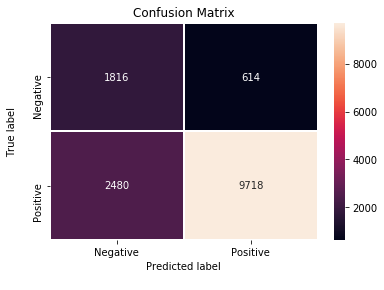

In [235]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

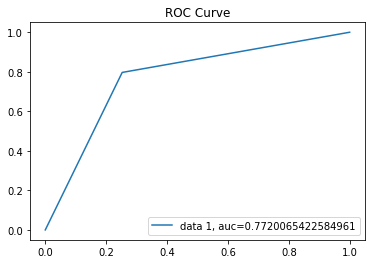

In [236]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [237]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [238]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [239]:
Pretty.add_row(["Random Forest","TF - IDF Weighted W2V",
                (clf.best_params_['n_estimators'],clf.best_params_['max_depth']),
                elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [240]:
print(Pretty)

|     Model     | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|    XG Boost   |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
|    XG Boost   |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |
|    XG Boost   |       Average W2V       |    (50, 13, 0.01)    | 1068.6631660461426 |      0.91     |    0.82    |
|    XG Boost   |   TF - IDF Weigted W2V  |   (50, 15, 0.005)    | 1068.6631660461426 |      0.89     |    0.82    |
| Random Forest |       Bag of Words      |     (300, None)      | 1137.6648106575012 |      0.93     |    0.75    |
| Random Forest |       Bag of Words      |     (800, None)      | 2152.808084964752  |      0.94     |    0.76    |
| Random Forest |       Average W2V       |     (300, None)      | 819.7472834587097  |      0.89     |    0.7     |
| Random Forest |  TF - IDF Weighted W2V  |     (300, None)     

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [25]:
# Formaing Output using pretty table
Pretty = PrettyTable(["Model","Vectorization Algorithm","Best Hyper Parameter","Elapsed Time"," Train Score ","Test Score"])
Pretty.set_style(MSWORD_FRIENDLY)
print(Pretty)

| Model | Vectorization Algorithm | Best Hyper Parameter | Elapsed Time |  Train Score  | Test Score |


In [26]:
final['Preprocessed Review Text'] = preprocessed_reviews

In [27]:
final_dataset = final.sort_values(by='Time',ascending=1)

In [28]:
# create design matrix X and target vector y
Y = np.array(final_dataset['Score']) # showing you two ways of indexing a pandas df
final_dataset.drop(['Score'],axis=1,inplace=True)
X = np.array(final_dataset.iloc[:, 0:12]) # end index is exclusive


In [29]:
#Time based split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [30]:
#Splitting the Dataset into Train set & Test set
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   Y_train, Y_test = Y[train_index], Y[test_index]

TRAIN: [    0     1     2 ... 14630 14631 14632] TEST: [14633 14634 14635 ... 29258 29259 29260]
TRAIN: [    0     1     2 ... 29258 29259 29260] TEST: [29261 29262 29263 ... 43886 43887 43888]
TRAIN: [    0     1     2 ... 43886 43887 43888] TEST: [43889 43890 43891 ... 58514 58515 58516]
TRAIN: [    0     1     2 ... 58514 58515 58516] TEST: [58517 58518 58519 ... 73142 73143 73144]
TRAIN: [    0     1     2 ... 73142 73143 73144] TEST: [73145 73146 73147 ... 87770 87771 87772]


In [31]:
# Checking the shape of the Train & Test sets
print(X_train.shape)
print(X_test.shape)
print('-------------------')
print(Y_train.shape)
print(Y_test.shape)

(73145, 10)
(14628, 10)
-------------------
(73145,)
(14628,)


In [32]:
# Converting X_Train, X_cv & X_test data is  to Dataframe for the ease of use
X_train_data=pd.DataFrame(X_train, columns=[ 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time',
       'Summary', 'Text', 'CleanedText']) 

X_test_data=pd.DataFrame(X_test, columns=[ 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time',
       'Summary', 'Text', 'CleanedText']) 


In [33]:
#Bow
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train_data['CleanedText'])

X_Train = count_vect.transform(X_train_data['CleanedText'])
print("Shape of out text BOW vectorizer ",X_Train.get_shape())
print("Number of unique words ", X_Train.get_shape()[1])

X_Test = count_vect.transform(X_test_data['CleanedText'])
print("Shape of out text BOW vectorizer ",X_Test.get_shape())
print("Number of unique words ", X_Test.get_shape()[1])

Shape of out text BOW vectorizer  (73145, 50169)
Number of unique words  50169
Shape of out text BOW vectorizer  (14628, 50169)
Number of unique words  50169


In [34]:
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_Train)
X_Train_Scaler = scaler_x.transform(X_Train)
X_Test_Scaler = scaler_x.transform(X_Test)

/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
#Hyper Parameters Set
params = {'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15],
          'min_samples_split': [10, 25, 50, 75, 100],
          'eta':[0.01,0.05,0.001,0.005]}

In [36]:
# Decision Tree Classifier
model =xgb.XGBClassifier()

scorer=make_scorer(roc_auc_score,needs_threshold= True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=10,n_jobs=-1)

In [37]:
%%time
start_time=time.time()
clf.fit(X_Train_Scaler,Y_train)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  6.4min remaining:   42.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.5min finished


CPU times: user 1min 17s, sys: 154 ms, total: 1min 17s
Wall time: 8min 47s


In [38]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.9162107431768468
The Best Parameter obtained from the Grid Search is :  {'min_samples_split': 50, 'max_depth': 15, 'eta': 0.001}


In [39]:
model = xgb.XGBClassifier(min_samples_split=clf.best_params_['min_samples_split'],
                          max_depth=clf.best_params_['max_depth'], eta=clf.best_params_['eta'],random_state=42)

In [40]:
model.fit(X_Train_Scaler,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.001, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=1,
       min_samples_split=50, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [41]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the XG Boost Classifier for Min Samples Split = %0.0f & Max Depth = %0.0f & eta = %0.3f is %0.2f' % (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta'], Test_score))

The Test Score of the Naive Bayes Classifier for Min Samples Split = 50 & Max Depth = 15 & eta = 0.001 is 0.88


In [42]:
Conf_matrix=confusion_matrix(Y_test, pred)

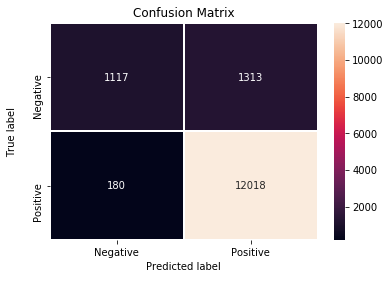

In [43]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

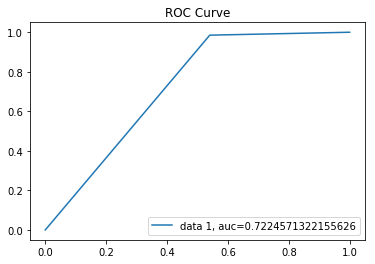

In [44]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [45]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [46]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [48]:
Pretty.add_row(["XG Boost","Bag of Words",
                (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta']),
                elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [49]:
print(Pretty)

|  Model   | Vectorization Algorithm | Best Hyper Parameter |   Elapsed Time   |  Train Score  | Test Score |
| XG Boost |       Bag of Words      |   (50, 15, 0.001)    | 527.069682598114 |      0.92     |    0.88    |


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

In [50]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_data['CleanedText'])

X_Train = tf_idf_vect.transform(X_train_data['CleanedText'])
print("the shape of out text TFIDF vectorizer ",X_Train.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Train.get_shape()[1])

X_Test = tf_idf_vect.transform(X_test_data['CleanedText'])
print("the shape of out text TFIDF vectorizer ",X_Test.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_Test.get_shape()[1])

the shape of out text TFIDF vectorizer  (73145, 43593)
the number of unique words including both unigrams and bigrams  43593
the shape of out text TFIDF vectorizer  (14628, 43593)
the number of unique words including both unigrams and bigrams  43593


In [51]:
# Standardization
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_Train)
X_Train_Scaler = scaler_x.transform(X_Train)
X_Test_Scaler = scaler_x.transform(X_Test)

In [52]:
#Hyper Parameters Set
params = {'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15],
          'min_samples_split': [10, 25, 50, 75],
          'eta':[0.01,0.05,0.001,0.005]}

In [53]:
# Decision Tree Classifier
model =xgb.XGBClassifier()

scorer=make_scorer(roc_auc_score,needs_threshold= True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [54]:
%%time
start_time=time.time()
clf.fit(X_Train_Scaler,Y_train)
elapsed_time = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.8min
/home/sujit/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.6min finished


CPU times: user 3min 12s, sys: 215 ms, total: 3min 12s
Wall time: 17min 48s


In [55]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.9252167244077656
The Best Parameter obtained from the Grid Search is :  {'min_samples_split': 25, 'max_depth': 15, 'eta': 0.005}


In [56]:
model = xgb.XGBClassifier(min_samples_split=clf.best_params_['min_samples_split'],
                          max_depth=clf.best_params_['max_depth'], eta=clf.best_params_['eta'],random_state=42)

In [57]:
model.fit(X_Train_Scaler,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.005, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=1,
       min_samples_split=25, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the XG Boost Classifier for Min Samples Split = %0.0f & Max Depth = %0.0f & eta = %0.3f is %0.2f' % (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta'], Test_score))

The Test Score of the Naive Bayes Classifier for Min Samples Split = 25 & Max Depth = 15 & eta = 0.005 is 0.89


In [59]:
Conf_matrix=confusion_matrix(Y_test, pred)

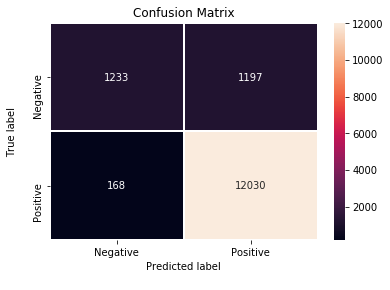

In [60]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

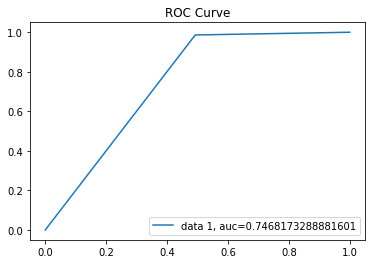

In [61]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [62]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [63]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [64]:
Pretty.add_row(["XG Boost","TF - IDF",
                (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta'])
                ,elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [65]:
print(Pretty)

|  Model   | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
| XG Boost |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
| XG Boost |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |


### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [66]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train_data['CleanedText']:
    list_of_sentance.append(sentance.split())

In [67]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X_test_data['CleanedText']:
    list_of_sentance_test.append(sentance.split())

In [68]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=10,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    

[('fantastic', 0.8398094177246094), ('awesome', 0.8080992698669434), ('terrific', 0.8074957132339478), ('good', 0.8068280816078186), ('excellent', 0.7818549871444702), ('wonderful', 0.7451878786087036), ('perfect', 0.7339023351669312), ('nice', 0.6990510821342468), ('amazing', 0.6976372599601746), ('decent', 0.6747597455978394)]
[('greatest', 0.7735941410064697), ('best', 0.7480399012565613), ('nastiest', 0.7060184478759766), ('tastiest', 0.7032496929168701), ('coolest', 0.6709749102592468), ('disgusting', 0.6467131972312927), ('smoothest', 0.6457651853561401), ('closest', 0.6418823003768921), ('nicest', 0.6171256303787231), ('awful', 0.6117835640907288)]


In [69]:
w2v_words = list(w2v_model.wv.vocab)

In [70]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 73145/73145 [02:13<00:00, 546.41it/s]

73145
50


In [71]:
X_train=sent_vectors

In [72]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 14628/14628 [00:26<00:00, 552.08it/s]

14628
50


In [73]:
X_Test=sent_vectors

In [74]:
# Standardization
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_train)
X_Train_Scaler = scaler_x.transform(X_train)
X_Test_Scaler = scaler_x.transform(X_Test)

In [75]:
#Hyper Parameters Set
params = {'max_depth' : [1, 3, 5, 7, 9, 11, 13],
          'min_samples_split': [10, 25, 50, 75],
          'eta':[0.01,0.05,0.001]}

In [76]:
# Decision Tree Classifier
model =xgb.XGBClassifier()

scorer=make_scorer(roc_auc_score,needs_threshold= True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [77]:
clf.fit(X_Train_Scaler,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.3min finished


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f5d91124390>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13], 'min_samples_split': [10, 25, 50, 75], 'eta': [0.01, 0.05, 0.001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(roc_auc_score, needs_threshold=True),
          verbose=5)

In [78]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.9072266803861927
The Best Parameter obtained from the Grid Search is :  {'min_samples_split': 50, 'max_depth': 13, 'eta': 0.01}


In [79]:
model = xgb.XGBClassifier(min_samples_split=clf.best_params_['min_samples_split'],
                          max_depth=clf.best_params_['max_depth'], eta=clf.best_params_['eta'],random_state=42)

In [80]:
model.fit(X_Train_Scaler,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.01, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=13, min_child_weight=1,
       min_samples_split=50, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [81]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the XG Boost Classifier for Min Samples Split = %0.0f & Max Depth = %0.0f & eta = %0.3f is %0.2f' % (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta'], Test_score))

The Test Score of the Naive Bayes Classifier for Min Samples Split = 50 & Max Depth = 13 & eta = 0.010 is 0.82


In [82]:
Conf_matrix=confusion_matrix(Y_test, pred)

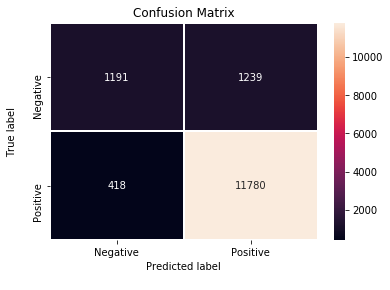

In [83]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

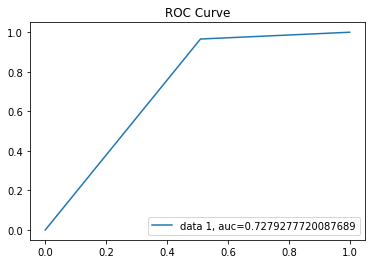

In [84]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [85]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [86]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [87]:
Pretty.add_row(["XG Boost","Average W2V",
                (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta']),
                elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

In [88]:
print(Pretty)

|  Model   | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
| XG Boost |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
| XG Boost |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |
| XG Boost |       Average W2V       |    (50, 13, 0.01)    | 1068.6631660461426 |      0.91     |    0.82    |


### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

In [89]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train_data['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 73145/73145 [47:11<00:00, 25.83it/s]  


In [91]:
X_Train=tfidf_sent_vectors

In [92]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 14628/14628 [09:12<00:00, 26.49it/s]


In [93]:
X_Test=tfidf_sent_vectors

In [94]:
# Standardization
scaler = StandardScaler(with_mean=False)
scaler_x = scaler.fit(X_Train)
X_Train_Scaler = scaler_x.transform(X_Train)
X_Test_Scaler = scaler_x.transform(X_Test)

In [95]:
#Hyper Parameters Set
params = {'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15],
          'min_samples_split': [10, 25, 50, 75, 100],
          'eta':[0.01,0.05,0.001,0.005]}

In [96]:
# Decision Tree Classifier
model =xgb.XGBClassifier()

scorer=make_scorer(roc_auc_score,needs_threshold= True)
   
my_cv = TimeSeriesSplit(n_splits=3).split(X_Train_Scaler)

clf = RandomizedSearchCV(estimator=model,scoring=scorer,cv=my_cv,param_distributions=params,verbose=5,n_jobs=-1)

In [97]:
clf.fit(X_Train_Scaler,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.4min finished


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f5d9150b228>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15], 'min_samples_split': [10, 25, 50, 75, 100], 'eta': [0.01, 0.05, 0.001, 0.005]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(roc_auc_score, needs_threshold=True),
          verbose=5)

In [98]:
print('The Best Mean Score obtained from the Grid Search is : ',clf.best_score_)
print('The Best Parameter obtained from the Grid Search is : ',clf.best_params_)
Train_score=clf.best_score_

The Best Mean Score obtained from the Grid Search is :  0.8861367701630996
The Best Parameter obtained from the Grid Search is :  {'min_samples_split': 50, 'max_depth': 15, 'eta': 0.005}


In [99]:
model = xgb.XGBClassifier(min_samples_split=clf.best_params_['min_samples_split'],
                          max_depth=clf.best_params_['max_depth'], eta=clf.best_params_['eta'],random_state=42)

In [100]:
model.fit(X_Train_Scaler,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.005, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=1,
       min_samples_split=50, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [101]:
pred = model.predict(X_Test_Scaler)
Test_score = roc_auc_score(pred,Y_test)
print('The Test Score of the XG Boost Classifier for Min Samples Split = %0.0f & Max Depth = %0.0f & eta = %0.3f is %0.2f' % (clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta'], Test_score))

The Test Score of the Naive Bayes Classifier for Min Samples Split = 50 & Max Depth = 15 & eta = 0.005 is 0.82


In [102]:
Conf_matrix=confusion_matrix(Y_test, pred)

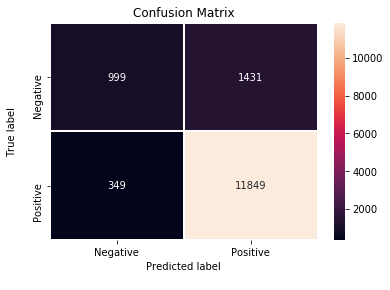

In [103]:
from matplotlib import *
import matplotlib.pyplot as plt

#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sns.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

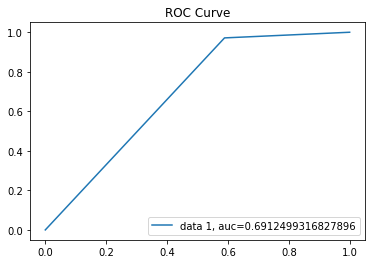

In [104]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  pred)
auc = metrics.roc_auc_score(Y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [105]:
TN,FP,FN,TP = Conf_matrix.ravel()
#confusion_matrix(Y_test, pred)

In [106]:
# Sensitivity, hit rate, recall, or true positive rate
TPR ='{0:.2%}'.format(TP/(TP+FN))
# Specificity or true negative rate
TNR ='{0:.2%}'.format(TN/(TN+FP))
# Fall out or false positive rate
FPR ='{0:.2%}'.format(FP/(FP+TN))
# False negative rate
FNR ='{0:.2%}'.format(FN/(TP+FN))
# Precision or positive predictive value
PPV ='{0:.2%}'.format(TP/(TP+FP))
# Negative predictive value
NPV ='{0:.2%}'.format(TN/(TN+FN))
# Overall accuracy
ACC ='{0:.2%}'.format((TP+TN)/(TP+FP+FN+TN))

In [107]:
Pretty.add_row(["XG Boost","TF - IDF Weigted W2V",(clf.best_params_['min_samples_split'],clf.best_params_['max_depth'],clf.best_params_['eta']),elapsed_time,'{0:.2}'.format(Train_score),'{0:.2}'.format(Test_score)])

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library

## Conclusion :
From the result, we can conclude that XG Boost got better auc score on test set.

In [249]:
print(Pretty)

|     Model     | Vectorization Algorithm | Best Hyper Parameter |    Elapsed Time    |  Train Score  | Test Score |
|    XG Boost   |       Bag of Words      |   (50, 15, 0.001)    |  527.069682598114  |      0.92     |    0.88    |
|    XG Boost   |         TF - IDF        |   (25, 15, 0.005)    | 1068.6631660461426 |      0.93     |    0.89    |
|    XG Boost   |       Average W2V       |    (50, 13, 0.01)    | 1068.6631660461426 |      0.91     |    0.82    |
|    XG Boost   |   TF - IDF Weigted W2V  |   (50, 15, 0.005)    | 1068.6631660461426 |      0.89     |    0.82    |
| Random Forest |       Bag of Words      |     (300, None)      | 1137.6648106575012 |      0.93     |    0.75    |
| Random Forest |       Average W2V       |     (300, None)      | 819.7472834587097  |      0.89     |    0.7     |
| Random Forest |  TF - IDF Weighted W2V  |     (300, None)      | 840.7916095256805  |      0.87     |    0.68    |
| Random Forest |         TF - IDF        |     (800, None)     